# Imports & Inits

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Generator Forward Pass (Linear)

- Implement the forward pass of a Generator network using only linear (fully-connected) layers and activation functions.
- 
    The first N−1N−1 layers use ReLU activation: hnew=ReLU(holdW+b)hnew​=ReLU(hold​W+b).
    The final layer uses Tanh activation: y=Tanh(holdW+b)y=Tanh(hold​W+b).

- 
    z: Latent input vectors of shape (batch_size, input_dim).
    weights: A list of weight matrices [W_0, W_1, ..., W_{N-1}].
        Each WiWi​ has shape (in_dim, out_dim).
    biases: A list of bias vectors [b_0, b_1, ..., b_{N-1}].
        Each bibi​ has shape (out_dim,).


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim) -> None:
        super(Generator, self).__init__()

        self.layers = nn.ModuleList()
        
        # Input layer 
        last_dim = latent_dim 
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, h_dim))
            last_dim = h_dim 
            
        self.output_layer = nn.Linear(last_dim, output_dim)
        
    def forward(self, z):
        h = z
        for layer in self.layers:
            h = F.relu(layer(h))
        return torch.tanh(self.output_layer(h))

# Minibatch Discrimination (GANs)

Minibatch Discrimination is a technique used in GAN discriminators to reduce **mode collapse** by allowing the discriminator to consider **relationships between samples in a minibatch**, rather than evaluating each sample independently.

---

## Definitions

- **N**: batch size  
- **A**: input feature dimension  
- **B**: number of kernels  
- **C**: kernel dimension  

---

## Inputs

- **features**  
  Shape: `(N, A)`  
  Activations from a discriminator layer.

- **T**  
  Shape: `(A, B, C)`  
  Learnable transformation tensor.

---

## Step 1: Linear Projection

We compute:

$$
M = f(x) \cdot T
$$

Implementation details:

- Reshape \( T \) from `(A, B, C)` to `(A, B \cdot C)`
- Perform matrix multiplication
- Reshape the result to `(N, B, C)`

Final shape:

$$
M \in \mathbb{R}^{N \times B \times C}
$$

---

## Step 2: Pairwise L1 Distances

For each kernel \( b \in \{1, \dots, B\} \), compute the L1 distance between all samples:

$$
d_{i,j}^{(b)} = \sum_{c=1}^{C} \left| M_{i,b,c} - M_{j,b,c} \right|
$$

This produces:

$$
d \in \mathbb{R}^{N \times N \times B}
$$

---

## Step 3: Exponential Similarity

Convert distances into similarity scores:

$$
o_b(x_i) = \sum_{j=1}^{N} \exp\left(-d_{i,j}^{(b)}\right)
$$

---

## Step 4: Remove Self-Comparison (Optional)

Since:

$$
d_{i,i}^{(b)} = 0 \Rightarrow \exp(0) = 1
$$

We subtract self-similarity:

$$
o_b(x_i) \leftarrow o_b(x_i) - 1
$$

---

## Output

- **mb_features**  
  Shape: `(N, B)`

These features are typically concatenated with discriminator activations.


In [ ]:
# class MB_discriminator(nn.Module):
#     def __init__(self,in_features, out_features, intermediate_dim):
#         super().__init__()
    
#         self.in_features = in_features
#         self.out_features = out_features # B
#         self.intermediate_dim = intermediate_dim # C

#         # The learnable matric (A, B, B)
#         self.T = nn.Parameter(torch.Tensor(in_features, out_features, intermediate_dim))
#         nn.init.normal_(self.T, std=0.1)

#     def forward(self, x):
#         # Step 1: Linear projection
#         # x is (N, A), T is (A, B, C) -> M is (N, B, C)
#         M = torch.matmul(x, self.T.view(self.in_features, -1))
#         M = M.view(-1, self.out_features, self.intermediate_dim)

#         # Step 2: Pairwise L1 distances
#         # We use unsqueeze to expand dimensions for broadcasting (N, 1, B, C) and (1, N, B, C)
#         M_i = M.unsqueeze(1) 
#         M_j = M.unsqueeze(0)

#         # Absolute difference and sum over C (axis=3)
#         distances = torch.abs(M_i - M_j).sum(dim= 3) # (N,N,B)

#         # Step 3: Exponential similarity (N, N, B) sum over columns -> (N, B)
#         # Note: subtracting 1 handles the self-comparison (e^0 = 1)
#         mb_features = torch.exp(-distances).sum(dim=0) - 1
        
#         return mb_features


# Discriminator Forward Pass (Linear)

- The discriminator consists of NN layers (typically small, e.g., 2 layers for simple problems).

    The first N−1N−1 layers use LeakyReLU activation with slope 0.20.2: hnew=LeakyReLU(holdW+b)hnew​=LeakyReLU(hold​W+b).
    The final layer uses Sigmoid activation: y=Sigmoid(holdW+b)y=Sigmoid(hold​W+b).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        """
        Args:
            input_dim: Total pixels (e.g., 784 for MNIST)
            hidden_dims: List of hidden layer sizes (e.g., [1024, 512, 256])
        """
        super(Discriminator, self).__init__()
        
        self.layers = nn.ModuleList()
        last_dim = input_dim
        
        # Build the main feature extraction trunk
        for h_dim in hidden_dims:
            # We use only Linear layers. 
            self.layers.append(nn.Linear(last_dim, h_dim))
            last_dim = h_dim
        
        # Reduce the last hidden dimension to a single scalar score
        self.output_layer = nn.Linear(last_dim, 1)

    def forward(self, x):
        # Ensure input is flattened if it comes in as (Batch, 1, 28, 28)
        
        h = x
        
        # Pass through the linear layers with LeakyReLU
        for layer in self.layers:
            # negative_slope=0.2
            h = F.leaky_relu(layer(h), negative_slope=0.2)
        
        # Return the raw validity score for WGAN
        validity = self.output_layer(h)
        
        return validity

# --- Quick Initialization Check ---
# IMAGE_DIM = 784
# D_HIDDEN = [512, 256]
# model = Discriminator(IMAGE_DIM, D_HIDDEN)
# print(model)

# WGAN-GP Gradient Penalty

The **Gradient Penalty** used in **WGAN-GP (Wasserstein GAN with Gradient Penalty)** enforces the **1-Lipschitz constraint** on the discriminator (also called the *critic*).  
Instead of weight clipping, WGAN-GP penalizes deviations of the gradient norm from 1.

---

## Intuition

For the Wasserstein distance to be valid, the critic must be **1-Lipschitz**.  
This means the gradient of the critic with respect to its input should have **unit norm everywhere**.

The gradient penalty softly enforces this by penalizing gradients whose L2 norm is not close to 1.

---

## Formula

## Definitions

- Gradient penalty coefficient

$$
\lambda = 10
$$

- Interpolated samples between real and generated data

$$
\hat{x}
$$

- Critic output evaluated at interpolated samples

$$
D(\hat{x})
$$

- Gradient of critic output with respect to interpolated input

$$
\nabla_{\hat{x}} D(\hat{x})
$$

- L2 (Euclidean) norm

$$
\lVert \cdot \rVert_2
$$

---

## Interpolated Samples

The interpolated inputs are defined as:

$$
\hat{x} = \epsilon x_{\text{real}} + (1 - \epsilon) x_{\text{fake}}
$$

where:

$$
\epsilon \sim \mathcal{U}(0, 1)
$$

---

## Inputs

- **gradients**  
  Shape: `(batch_size, input_dim)`  
  Gradients of the critic output with respect to interpolated inputs.

- **lambda_gp**  
  Scalar \( \lambda \) controlling penalty strength.

---

## Computation Steps

1. Compute the L2 norm of each gradient:
   $$
   \left\| \nabla_{\hat{x}} D(\hat{x}_i) \right\|_2
   $$

2. Subtract 1 from each norm:
   $$
   \left\| \nabla_{\hat{x}} D(\hat{x}_i) \right\|_2 - 1
   $$

3. Square the result:
   $$
   \left(
   \left\| \nabla_{\hat{x}} D(\hat{x}_i) \right\|_2 - 1
   \right)^2
   $$

4. Take the mean over the batch:
   $$
   \mathbb{E}[\cdot]
   $$

5. Multiply by \( \lambda \).

---

## Output

- **penalty**  
  Scalar value representing the mean gradient penalty over the batch.

---

## Why This Works

- Enforces the Lipschitz constraint smoothly
- More stable than weight clipping
- Improves convergence and training stability
- Prevents exploding or vanishing gradients in the critic

In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight 'alpha' for interpolation
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # Get discriminator output for these interpolates
    d_interpolates = discriminator(interpolates)
    
    # Create fake gradients for the 'grad' function to work with
    fake = torch.ones(real_samples.size(0), 1).to(device)
    
    # Get gradient of d_interpolates w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Calculate the penalty: ((norm - 1)^2)
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

# Logging Inits

In [ ]:
import os
from torchvision.utils import save_image

# --- Global Configuration ---
# Check for Apple MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success: Using Apple MPS acceleration.")
else:
    device = torch.device("cpu")
    print("Warning: MPS not found. Using CPU.")

Z_DIM = 100        # Size of the noise vector
BATCH_SIZE = 64    # Size of the batch

# --- Setup Logging & Visualization ---
# Create directory
os.makedirs("samples", exist_ok=True)

# Create the FIXED noise
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM).to(device)

# Initialize empty lists to track loss
img_list = []
G_losses = []
D_losses = []

print("Setup complete.")

Success: Using Apple MPS acceleration.
Setup complete. You can now run the training loop.


# Training Loop Initialization

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# ---  Configuration & Hyperparameters ---

LR = 1e-4
BATCH_SIZE = 64
Z_DIM = 100
IMG_DIM = 28 * 28  # 784 pixels
LAMBDA_GP = 10     # Standard penalty coefficient

# ---  Data Loading (CRITICAL FIX) ---
# We must re-define the dataset with Normalize((0.5,), (0.5,))
# This ensures inputs are [-1, 1], matching the Generator's Tanh output.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ---  Initialize Models ---
# Hidden dimensions based on your previous cells
generator = Generator(latent_dim=Z_DIM, hidden_dims=[256, 512, 1024], output_dim=IMG_DIM).to(device)
discriminator = Discriminator(input_dim=IMG_DIM, hidden_dims=[1024, 512, 256]).to(device)

# ---  Optimizers ---
# beta1=0.0 is crucial for WGAN stability
opt_gen = optim.Adam(generator.parameters(), lr=LR, betas=(0.0, 0.9))
opt_disc = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.0, 0.9))

# ---  Training Loop ---
NUM_EPOCHS = 10

# --- Training Loop ---
print(f"Starting training on {device}...")

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        
        # 1. Flatten images
        real = real.view(-1, IMG_DIM).to(device)
        cur_batch_size = real.shape[0]

        # ==================================
        #  TRAIN DISCRIMINATOR (The Critic)
        # ==================================
        
        # Initialize to None so scope exists
        loss_critic = None 

        # Train the critic for 5 times  
        for _ in range(5): 
            noise = torch.randn(cur_batch_size, Z_DIM).to(device)
            fake = generator(noise)
            
            # Scores
            critic_real = discriminator(real)
            critic_fake = discriminator(fake)
            
            # Gradient Penalty
            gp = compute_gradient_penalty(discriminator, real, fake, device)
            
            # Loss
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            
            discriminator.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_disc.step()

        # ==================================
        #  TRAIN GENERATOR
        # ==================================
        
        # Create FRESH noise for the generator step
        noise = torch.randn(cur_batch_size, Z_DIM).to(device)
        gen_fake = generator(noise)
        gen_fake_score = discriminator(gen_fake)
        
        loss_gen = -torch.mean(gen_fake_score)
        
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # --- SAVE STATS & IMAGES ---
        if loss_critic is not None and loss_gen is not None:
            G_losses.append(loss_gen.item())
            D_losses.append(loss_critic.item())

            # Print progress & Save Images every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
                      f"Loss D: {loss_critic.item():.4f}, Loss G: {loss_gen.item():.4f}")
                
                with torch.no_grad():
                    # Generate images using the FIXED noise
                    fake_display = generator(fixed_noise).reshape(-1, 1, 28, 28)
                    
                    # UN-NORMALIZE: Convert [-1, 1] back to [0, 1] for saving
                    fake_display = fake_display * 0.5 + 0.5
                    
                    # Save the grid to the 'samples' folder
                    save_image(fake_display, f"samples/epoch_{epoch}_batch_{batch_idx}.png", normalize=False)

Starting training on mps...
Epoch [0/10] Batch 0/938 Loss D: 7.6236, Loss G: -0.0377
Epoch [0/10] Batch 100/938 Loss D: -12.3624, Loss G: -0.7565
Epoch [0/10] Batch 200/938 Loss D: -12.9425, Loss G: -0.2102
Epoch [0/10] Batch 300/938 Loss D: -11.8683, Loss G: -1.8472
Epoch [0/10] Batch 400/938 Loss D: -10.3341, Loss G: -1.8875
Epoch [0/10] Batch 500/938 Loss D: -8.0766, Loss G: -2.0751
Epoch [0/10] Batch 600/938 Loss D: -6.5198, Loss G: -2.7898
Epoch [0/10] Batch 700/938 Loss D: -6.5922, Loss G: -1.3395
Epoch [0/10] Batch 800/938 Loss D: -5.9062, Loss G: -0.3287
Epoch [0/10] Batch 900/938 Loss D: -5.7927, Loss G: 1.7727
Epoch [1/10] Batch 0/938 Loss D: -5.9319, Loss G: 3.1273
Epoch [1/10] Batch 100/938 Loss D: -6.7383, Loss G: 3.8905
Epoch [1/10] Batch 200/938 Loss D: -6.3063, Loss G: 4.1239
Epoch [1/10] Batch 300/938 Loss D: -6.2040, Loss G: 6.9082
Epoch [1/10] Batch 400/938 Loss D: -6.4508, Loss G: 6.4711
Epoch [1/10] Batch 500/938 Loss D: -6.1928, Loss G: 5.8411
Epoch [1/10] Batch 6

# Visualize

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 59.8 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


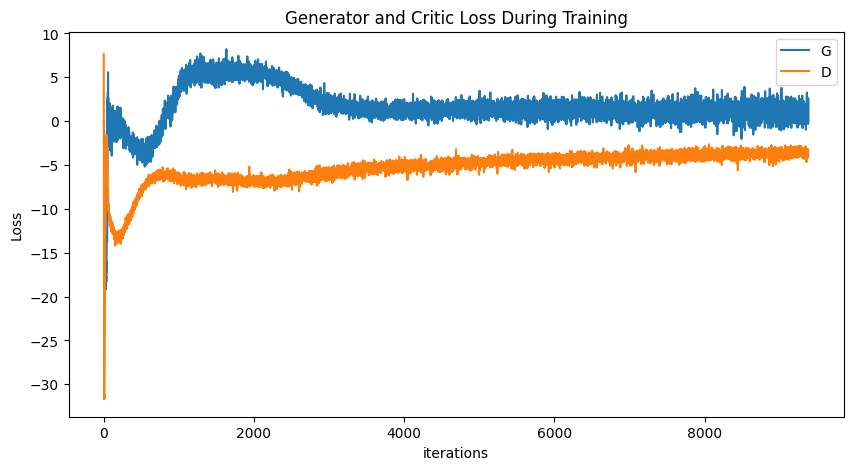

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save Model

In [44]:
torch.save(generator.state_dict(), "wgan_gp_generator.pth")
torch.save(discriminator.state_dict(), "wgan_gp_discriminator.pth")
print("Models saved successfully.")

Models saved successfully.


# Load model


In [45]:
import torch
import torchvision.utils as vutils

# Configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
Z_DIM = 100
IMG_DIM = 784

# Initialize and Load
loaded_gen = Generator(latent_dim=Z_DIM, hidden_dims=[256, 512, 1024], output_dim=IMG_DIM).to(device)
loaded_gen.load_state_dict(torch.load("wgan_gp_generator.pth", map_location=device))
loaded_gen.eval()

# Generate
with torch.no_grad():
    noise = torch.randn(64, Z_DIM).to(device)
    fake_images = loaded_gen(noise).reshape(-1, 1, 28, 28)
    
    # Un-normalize
    fake_images = fake_images * 0.5 + 0.5
    
    vutils.save_image(fake_images, "generated_inference.png", normalize=False)

print("Inference complete. Check 'generated_inference.png'")

Inference complete. Check 'generated_inference.png'
